In [26]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer
# import matplotlib.pyplot as plt
# import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# distribution_centers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/루커스 데이터셋/distribution_centers.csv')
# event = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/루커스 데이터셋/events.csv')
# inventory_items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/루커스 데이터셋/inventory_items.csv')
order_items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/루커스 데이터셋/order_items.csv')
# orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/루커스 데이터셋/orders.csv')
# products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/루커스 데이터셋/products.csv')
# users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종 프로젝트/루커스 데이터셋/users.csv')

# RFM-D(Diversity) 데이터 전처리

In [5]:
#필요한 데이터 전처리
order_items_extracted = order_items.query('status != "Returned" and status != "Cancelled"')
order_items_extracted = order_items_extracted[['user_id', 'order_id', 'created_at', 'status', 'product_id', 'sale_price']].sort_values(by = 'user_id')

# 년-월-일 형식의 문자열로 변환
order_items_extracted['created_at'] = pd.to_datetime(order_items_extracted['created_at'], format='ISO8601')
order_items_extracted['created_at'] = pd.to_datetime(order_items_extracted['created_at'].dt.strftime('%Y-%m-%d'))
order_items_extracted = order_items_extracted.rename(columns = {'created_at' : 'date'}).query('date < "2023-12-01"')

In [6]:
order_items_extracted['date'].max()

Timestamp('2023-11-30 00:00:00')

In [7]:
#recency
recency_data = order_items_extracted.groupby('user_id')['date'].max().reset_index()
recency_data['Recency'] = (order_items_extracted['date'].max()-recency_data['date']).dt.days
recency_data

#frequency
frequency_data = order_items_extracted.groupby('user_id')['order_id'].nunique().reset_index()
frequency_data.rename(columns={'order_id': 'Frequency'}, inplace=True)

#monetary
monetary_data = order_items_extracted.groupby('user_id')['sale_price'].sum().reset_index()
monetary_data.rename(columns={'sale_price': 'Monetary'}, inplace=True)

#diversity
diversity_data = order_items_extracted.groupby('user_id')['product_id'].nunique().reset_index()
diversity_data.rename(columns={'product_id': 'Diversity'}, inplace=True)

rfm_data = recency_data.merge(frequency_data, on='user_id').merge(monetary_data, on='user_id').merge(diversity_data, on='user_id')


rfm_data[['Recency', 'Frequency', 'Monetary', 'Diversity']].corr()

,Recency,Frequency,Monetary,Diversity
Recency,1.000000,-0.204449,-0.097105,-0.142660
Frequency,-0.204449,1.000000,0.472308,0.724000
Monetary,-0.097105,0.472308,1.000000,0.651669
Diversity,-0.142660,0.724000,0.651669,1.000000


In [8]:
rfm_data['Recency_log'] = np.log1p(rfm_data['Recency'])
rfm_data['Frequency_log'] = np.log1p(rfm_data['Frequency'])
rfm_data['Monetary_log'] = np.log1p(rfm_data['Monetary'])
rfm_data['Diversity_log'] = np.log1p(rfm_data['Diversity'])

X_features = rfm_data[['Recency_log', 'Frequency_log', 'Monetary_log', 'Diversity_log']]


# Diversity 넣을 경우

## 스탠다드 스케일 안 할 경우

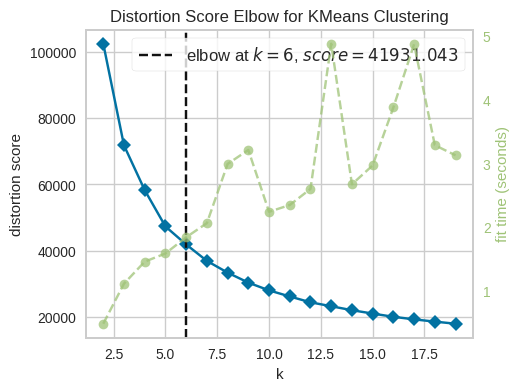

In [9]:
plt.figure(figsize=(5,4))
kmeans = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans,k=(2,20))
elbow.fit(X_features.values)
elbow.show()
plt.show()


In [10]:
#diversity 넣은 경우

#5일 경우 0.3199, 6일 경우 0.3068
kmeans = KMeans(n_clusters = 6, random_state = 42)

labels = kmeans.fit_predict(X_features)
rfm_data['label'] = labels

silhouette_score(X_features, labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.28392648565112977

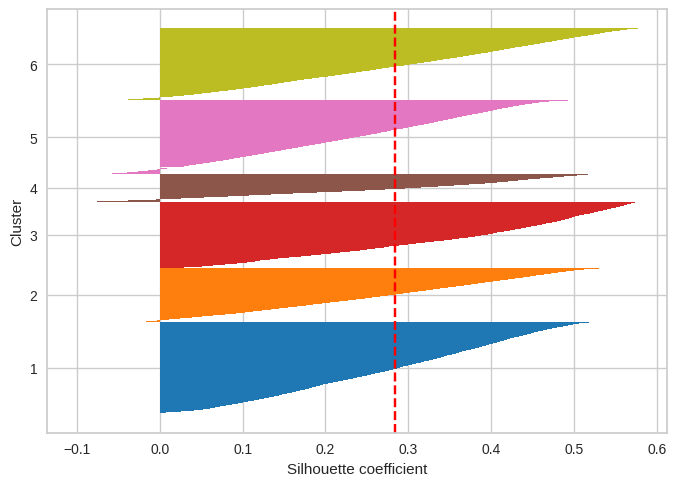

In [11]:
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_features, labels)

# 각 데이터 포인트의 클러스터 레이블을 가져옵니다.
cluster_labels = np.unique(labels)

# 실루엣 스코어를 그래프로 표시합니다.
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = plt.cm.tab10(i / len(cluster_labels))
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

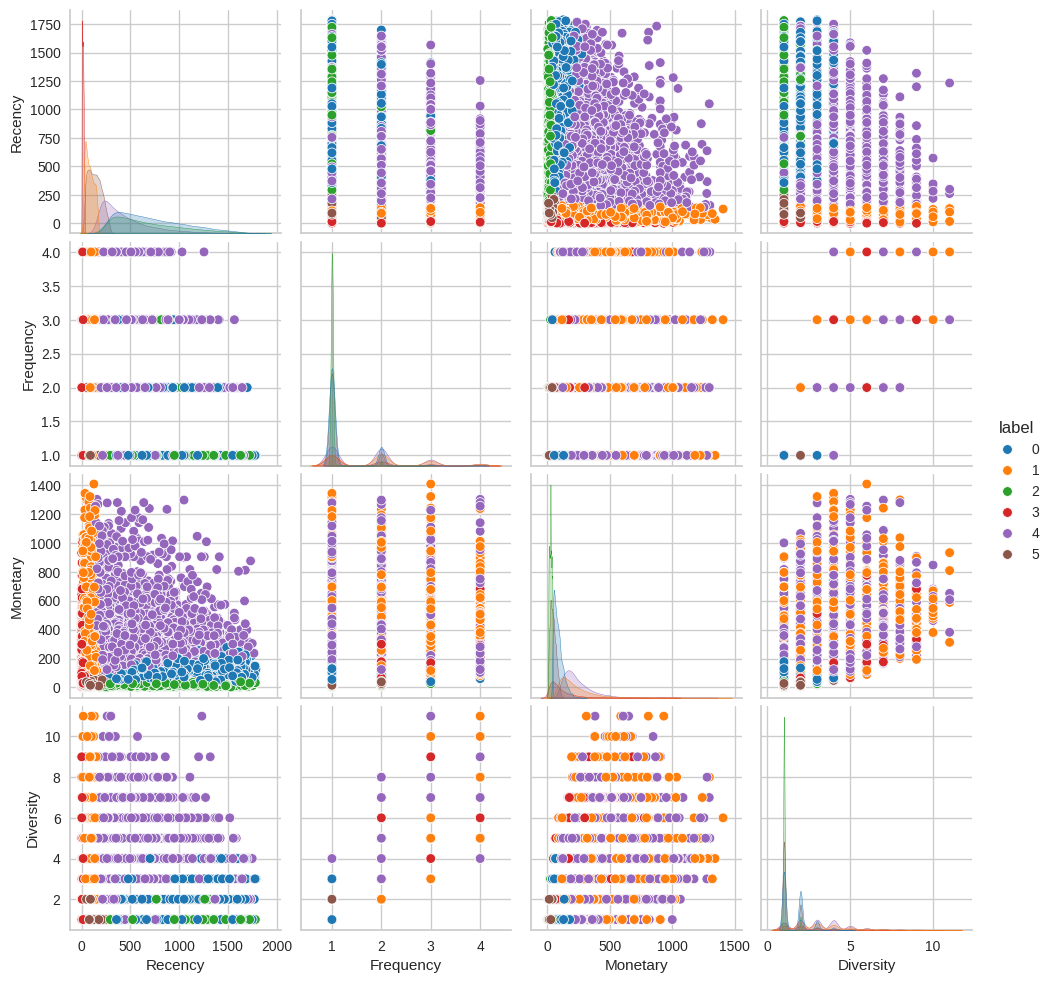

In [23]:
features = ['Recency', 'Frequency', 'Monetary', 'Diversity']

# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='label', palette='tab10', diag_kind='kde')


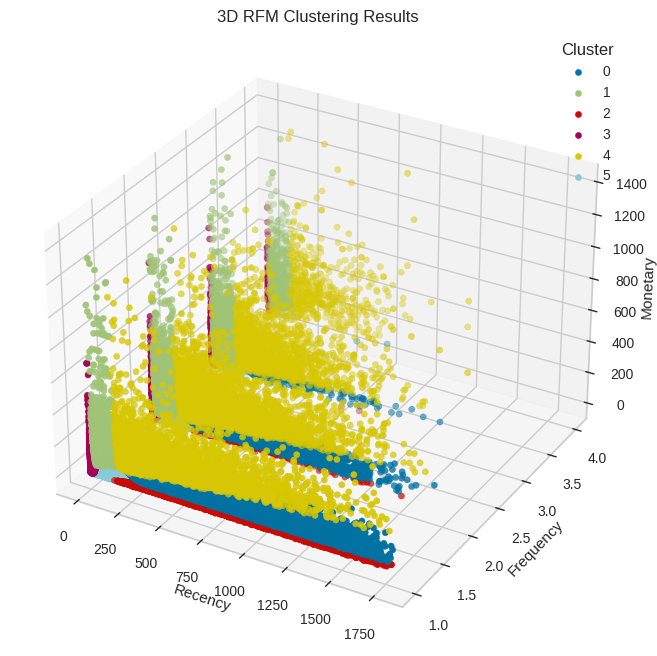

In [27]:
x_feature = 'Recency'
y_feature = 'Frequency'
z_feature = 'Monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('label'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')


## 스탠다드 스케일 할 경우

In [ ]:
X_features_sc

In [12]:
sc = StandardScaler()
X_features_sc = sc.fit_transform(X_features)
X_features_sc_df = pd.DataFrame(X_features_sc)
X_features_sc_df.rename(columns={0:'Recency_sc', 1:'Frequency_sc', 2:'Monetary_sc', 3:'Diversity_sc'}, inplace=True)


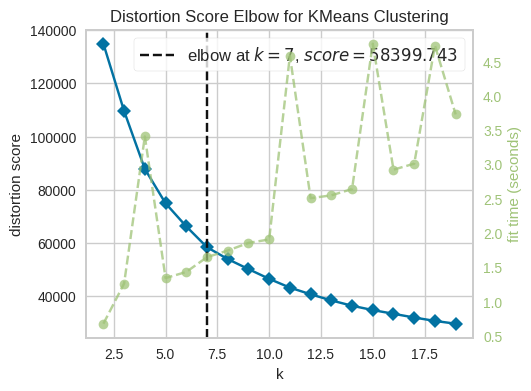

In [13]:
plt.figure(figsize=(5,4))
kmeans_sc = KMeans(random_state=42, n_init=10)
elbow_sc = KElbowVisualizer(kmeans_sc,k=(2,20))
elbow_sc.fit(X_features_sc_df.values)
elbow_sc.show()
plt.show()

In [14]:
kmeans_sc = KMeans(n_clusters = 7, random_state = 42)

labels_sc = kmeans_sc.fit_predict(X_features_sc_df)
rfm_data['label_sc'] = labels_sc

silhouette_score(X_features_sc_df, labels_sc)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.29579876739215333

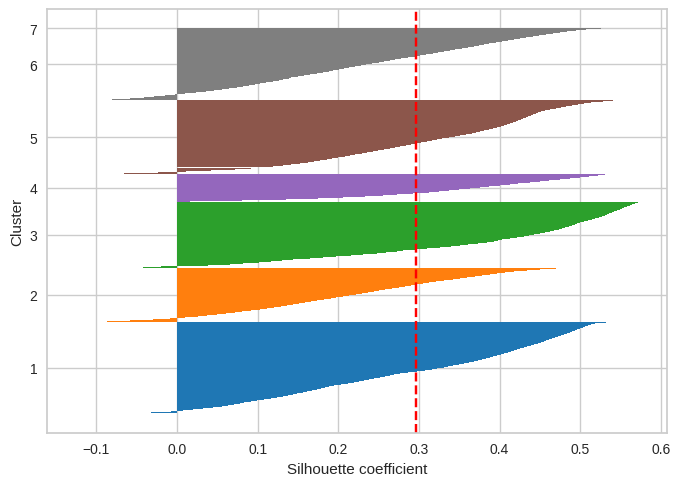

In [15]:
#from sklearn.metrics import silhouette_samples
silhouette_vals_sc = silhouette_samples(X_features_sc_df, labels_sc)

# 각 데이터 포인트의 클러스터 레이블을 가져옵니다.
cluster_labels_sc = np.unique(labels_sc)

# 실루엣 스코어를 그래프로 표시합니다.
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels_sc):
    c_silhouette_vals_sc = silhouette_vals_sc[labels == c]
    c_silhouette_vals_sc.sort()
    y_ax_upper += len(c_silhouette_vals_sc)
    color = plt.cm.tab10(i / len(cluster_labels_sc))
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals_sc, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals_sc)

silhouette_avg_sc = np.mean(silhouette_vals_sc)
plt.axvline(silhouette_avg_sc, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels_sc + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

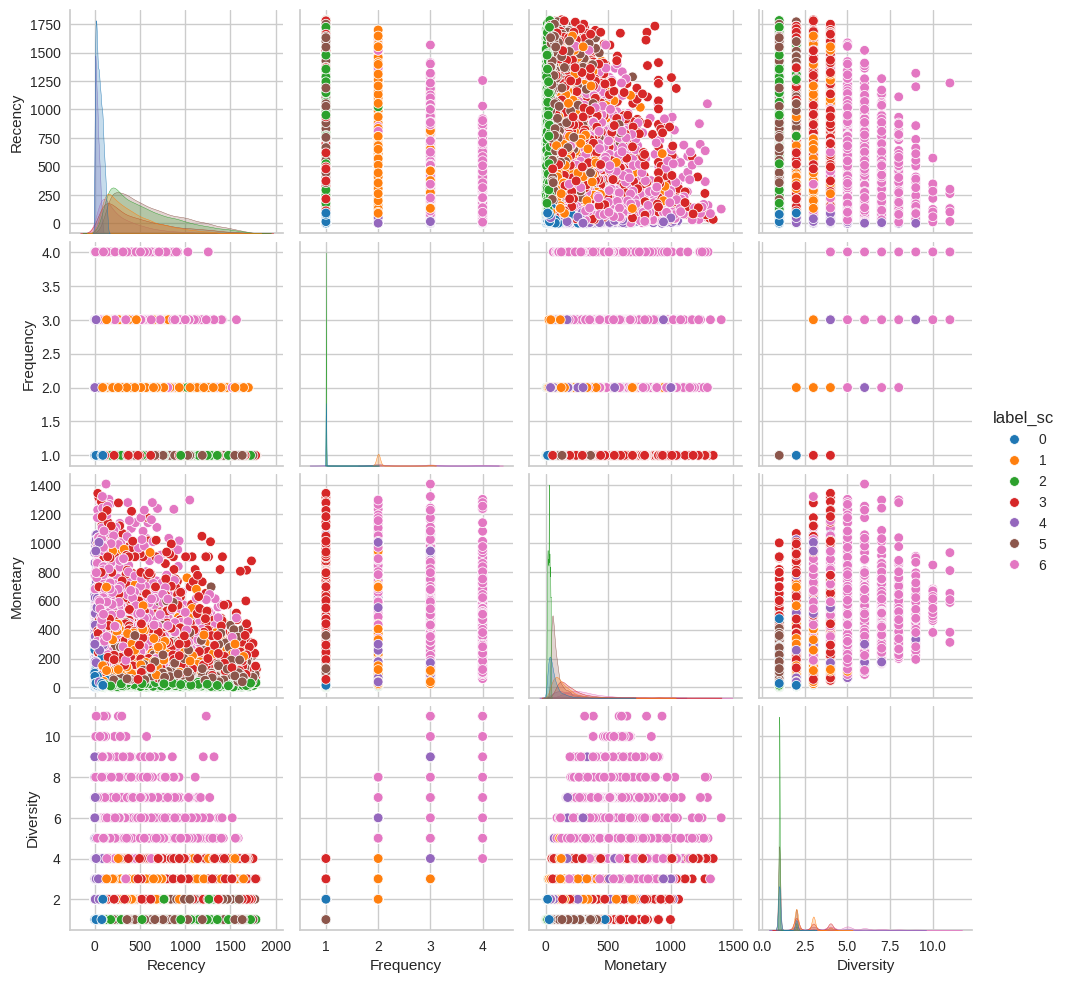

In [25]:
features = ['Recency', 'Frequency', 'Monetary', 'Diversity']

# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='label_sc', palette='tab10', diag_kind='kde')

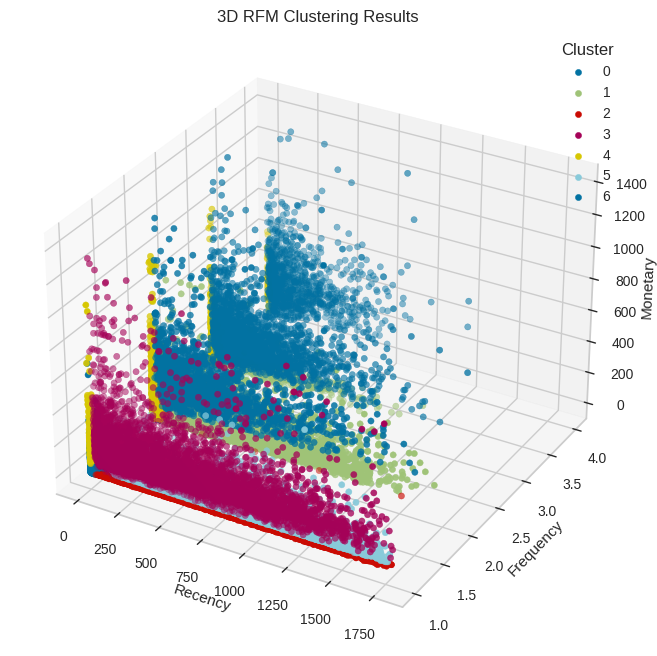

In [28]:
x_feature = 'Recency'
y_feature = 'Frequency'
z_feature = 'Monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('label_sc'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')
